<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction To Data Science @ FIT-HCMUS, VNU-HCM
</div>

<div style="text-align: center; background-color: #559CFF; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Model: Support Vector Machine
</div>

**The reason for choosing `SVMs` model.**

+ `SVMs` can handle both classification and regression on linear and non-linear data. This is one of the reasons we use `SVMs` in machine learning.
+ Another reason we use `SVMs` because they can find complex relationships between your data without you needing to do a lot of transformations on your own. It's a great option when you are working with smaller datasets that have tens to hundreds of thousands of features.

## Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import time
import csv

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Insert and preprocess data

### Load data
Load our data from path `../Data/processed_data.csv`.

In [3]:
# Load our data from path `../Data/processed_data.csv`
courses_df = pd.read_csv('../Data/processed_data.csv', sep=',',engine='python', encoding='utf-8')
courses_df.sample(5)

,name,general,specify,enrollment,language,rating,level,duration,instructor,instructor_rate,offered by
548,Building Batch Data Pipelines on GCP em Portug...,Information Technology,Cloud Computing,13926,Portuguese (Brazilian),4.7,Intermediate,16,Google Cloud Training,5.0,Google Cloud
2562,Hardware Security,Computer Science,Computer Security and Networks,32617,English,4.3,Other,12,Gang Qu,4.4,"University of Maryland, College Park"
3768,Machine Learning Foundations: A Case Study App...,Data Science,Machine Learning,383888,English,4.6,Other,18,"Carlos Guestrin, Emily Fox",4.7,University of Washington
3276,Fundamentals of Kubernetes Deployment,Computer Science,Mobile and Web Development,16916,English,4.3,Intermediate,8,Jim Sullivan,4.2,LearnQuest
4266,Recovering the Humankind's Past and Saving the...,Arts and Humanities,History,15760,English,4.4,Other,13,"Paolo Matthiae, Emanuel Demetrescu, Andrea Vit...",4.5,Sapienza University of Rome


### Preprocess data

- The `name` and `instructor` features needs to be removed because it is not useful in training the model.

In [4]:
data_ = courses_df.copy().drop(columns=['name', 'instructor'])
data_.sample(5)

,general,specify,enrollment,language,rating,level,duration,instructor_rate,offered by
13,Business,Entrepreneurship,2136,Portuguese (Brazilian),5.0,Other,3,4.8,Goldman Sachs
4589,Data Science,Probability and Statistics,143965,English,4.4,Other,53,4.5,Johns Hopkins University
4831,Health,Basic Science,14532,Chinese (Simplified),4.8,Other,42,5.0,Nanjing University
2168,Business,Leadership and Management,6151,English,4.5,Beginner,12,4.5,West Virginia University
1868,Health,Public Health,9849,English,4.7,Beginner,5,4.9,Johns Hopkins University


- Explore missing values in variables:
    + View summary of dataset.

In [5]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   general          5717 non-null   object 
 1   specify          5717 non-null   object 
 2   enrollment       5718 non-null   int64  
 3   language         5718 non-null   object 
 4   rating           5718 non-null   float64
 5   level            5718 non-null   object 
 6   duration         5718 non-null   int64  
 7   instructor_rate  5718 non-null   float64
 8   offered by       5703 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 402.2+ KB


In [6]:
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general             1
specify             1
enrollment          0
language            0
rating              0
level               0
duration            0
instructor_rate     0
offered by         15
dtype: int64


- Explore missing values in variables:
    + Drop rows with missing values: Because the number of missing values each variable is insignificant, we will remove rows containing missing data.

In [7]:
# Drop rows with missing values
data_.dropna(inplace=True)
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general            0
specify            0
enrollment         0
language           0
rating             0
level              0
duration           0
instructor_rate    0
offered by         0
dtype: int64


## Prepare for training model

In [ ]:
# handle for duration
Q1 = data_['duration'].quantile(0.25)
Q3 = data_['duration'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

data_.loc[data_['duration'] > upper_bound, 'duration'] = int(upper_bound)
data_.loc[data_['duration'] < lower_bound, 'duration'] = max(int(lower_bound), 0)


# # handle for enrollment
Q1 = data_['enrollment'].quantile(0.25)
Q3 = data_['enrollment'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

data_.loc[data_['enrollment'] > upper_bound, 'enrollment'] = int(upper_bound)
data_.loc[data_['enrollment'] < lower_bound, 'enrollment'] = max(int(lower_bound), 0)

### Define kind of features

- Define selection and target features to prepare data for training model.

In [8]:
# Define selection and target features to prepare data for training model
target = ['rating']
specificities = list(set(data_.columns) - set(target))

- Define numerical and categorical features to transformer.

In [9]:
# Define numerical and categorical features
numeracy_ = list(set(specificities) - set(courses_df.select_dtypes(include=['object']).columns))
category_ = list(set(specificities) - set(courses_df.select_dtypes(exclude=['object']).columns))
print('Numerical features:', numeracy_)
print('Categorical features:', category_)

Numerical features: ['instructor_rate', 'duration', 'enrollment']
Categorical features: ['specify', 'language', 'level', 'general', 'offered by']


### Split data
Split data into 2 datasets: `Training dataset` and `Testing dataset`. We’ll perform splitting on the following ratio 80-20.

In [10]:
# Define the constant variable random_state
random_state = 2112

# Select features and target variable
X = data_[specificities]
y = data_[target]

# Split data on the following ratio 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)

### Initialize transformer

In [11]:
# Create transformer for numerical and categorical features by using Pipeline
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeracy_),
                                               ('cat', cat_transformer, category_)])

### Search hyperparameter for available data fitting model

- When tuning the hyperparameter, I use `GridSearchCV`.
- While setting up the `Pipeline` for `GridSearchCV`, I set the variable value `cv=4`.
    + This means that `GridSearchCV` will divide the training dataset into 4 sub-datasets.
    + Each sub-dataset will be used as a **_validation dataset_** while the others will be used for **_training_** and **_hyperparameter-tuning_**.
- To calculate the **Mean Squared Error** (MSE) score, `GridSearchCV` will take the average of splitting the training dataset 4 times.

We take into account some essential hyperparameters for fine-tuning SVMs:
- **`C`**: The regularization parameter that controls the trade-off between the margin and the number of training errors. A larger value of C penalizes training errors more heavily, resulting in a smaller margin but potentially better generalization performance. A smaller value of C allows for more training errors but may lead to overfitting.
- **`Kernel`**: The kernel function that defines the similarity between data points. Different kernels can capture different relationships between data points, and the choice of kernel can significantly impact the performance of the SVM. Common kernels include linear, polynomial, radial basis function (RBF), and sigmoid.
- **`Gamma`**: The parameter that controls the influence of support vectors on the decision boundary. A larger value of gamma indicates that nearby support vectors have a stronger influence, while a smaller value indicates that distant support vectors have a weaker influence. The choice of gamma is particularly important for RBF kernels.

In [12]:
# Use SVR for regression
pipe_svm = Pipeline([('preprocessor', preprocessor),
                      ('regressor', SVR())])

# Fine-tuning hyperparameters
param_kernel = ['linear', 'rbf', 'sigmoid', 'poly']
param_C = [0.01, 0.1, 1.0, 10.0]
param_gamma = [0.001, 0.01, 0.1, 1.0]
param_grid = [{'regressor__C': param_C,
               'regressor__kernel': param_kernel,
               'regressor__gamma': param_gamma}]

# Use a regression-specific scoring metric
reg_gs = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    cv=4)

reg_gs = reg_gs.fit(X_train, y_train)

In [13]:
# Get scoring values of ref_gs
recording_df = pd.DataFrame({'kernel':np.ma.getdata(reg_gs.cv_results_['param_regressor__kernel']),
                             'C':np.ma.getdata(reg_gs.cv_results_['param_regressor__C']),
                             'gamma':np.ma.getdata(reg_gs.cv_results_['param_regressor__gamma']),
                             'mean_test':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_test_score'].round(6)],
                             'mean_train':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_train_score'].round(6)],
                             'rank_test_score':reg_gs.cv_results_['rank_test_score'],
                             'mean_fit_time': reg_gs.cv_results_['mean_fit_time'],
                             'mean_score_time': reg_gs.cv_results_['mean_score_time']},
                            index=reg_gs.cv_results_['params'])\
                                .sort_values(by=['kernel', 'C', 'gamma'], ascending=[True, True, True])
recording_df.to_csv('record_hyperparameters_svm.csv', encoding='utf-8-sig')

Since hyperparameter-tuning is time-consuming, I have saved the table that records the **Mean Squared Error** (**MSE**) data results to a `record_hyperparameters_svm.csv` file. By doing so, I can retrieve the saved data later on to explore the results, saving my time in case of interruptions during the project. This way, I can avoid redoing the hyperparameter tuning process.

In [3]:
# Read recording data from record_hyperparameters_svm.csv
recording_save_df = pd.read_csv('record_hyperparameters_svm.csv', sep=',', engine='python', encoding='utf-8', index_col=[0])
recording_save_df

,kernel,C,gamma,mean_test,mean_train,rank_test_score,mean_fit_time,mean_score_time
"{'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.01,0.001,3.442900e-02,3.301200e-02,17,0.803603,0.129681
"{'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'linear'}",linear,0.01,0.010,3.442900e-02,3.301200e-02,17,0.707126,0.128755
"{'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'linear'}",linear,0.01,0.100,3.442900e-02,3.301200e-02,17,0.708554,0.135978
"{'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'linear'}",linear,0.01,1.000,3.442900e-02,3.301200e-02,17,0.704557,0.132843
"{'regressor__C': 0.1, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.10,0.001,3.400200e-02,3.061800e-02,4,0.918764,0.156690
...,...,...,...,...,...,...,...,...
"{'regressor__C': 1.0, 'regressor__gamma': 1.0, 'regressor__kernel': 'sigmoid'}",sigmoid,1.00,1.000,3.036000e+04,3.213924e+04,62,2.630720,0.805955
"{'regressor__C': 10.0, 'regressor__gamma': 0.001, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.001,3.443000e-02,3.301500e-02,21,0.954268,0.174146
"{'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.010,5.870744e+00,5.664162e+00,58,1.601314,0.324319
"{'regressor__C': 10.0, 'regressor__gamma': 0.1, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.100,6.987010e+04,6.859291e+04,63,2.369085,0.745141


- Let's see the execution time while fitting the model.

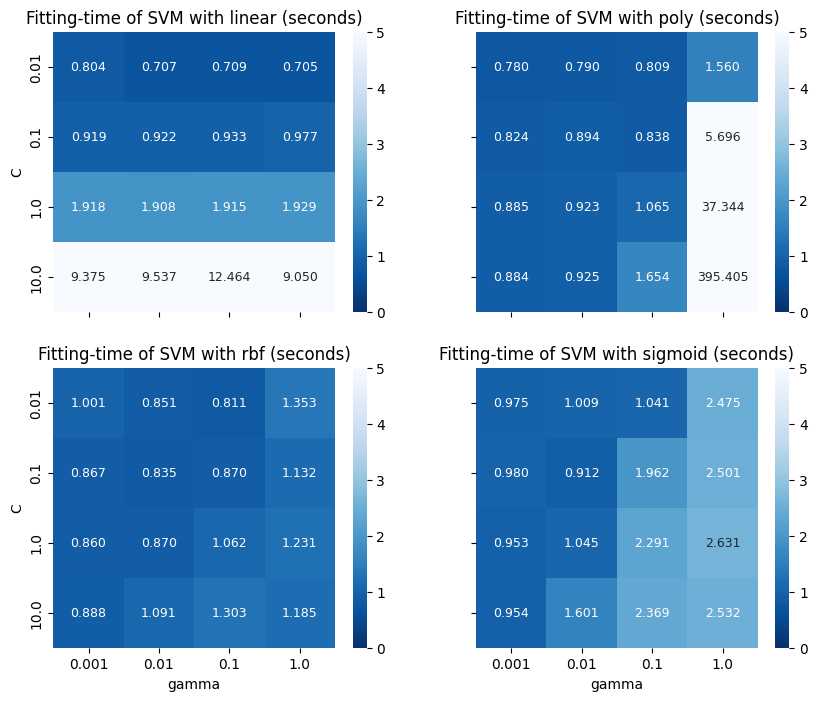

In [5]:
heatmap_df = recording_save_df.copy().reset_index().drop(columns=['index', 'mean_test', 'mean_train', 'rank_test_score']).set_index(['kernel'])

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

# Plot heatmap each kernel
for index, kernel in enumerate(heatmap_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = heatmap_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['mean_fit_time'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    sns.heatmap(data_plot, annot=True, ax=ax,
                vmin=0, vmax=5.0, fmt='.3f',
                cmap='Blues_r', annot_kws={"size": 9})
    ax.set_title('Fitting-time of SVM with ' + kernel + ' (seconds)')
    if index % 2 == 0:
        ax.set_ylabel('C')
        
    if index // 2 == 1:
        ax.set_xlabel('gamma')

plt.show()

Let's examine the MSE value of each kernel through the relationship between `C` and `gamma`.

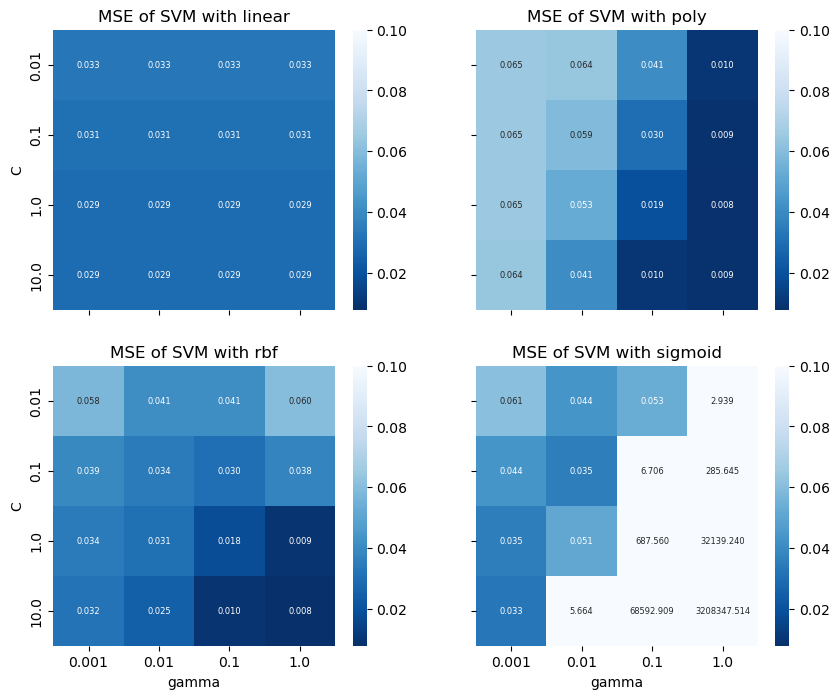

In [15]:
heatmap_df = recording_save_df.copy().reset_index().drop(columns=['index', 'mean_test', 'rank_test_score', 'mean_fit_time', 'mean_score_time']).set_index(['kernel'])
min_range = heatmap_df['mean_train'].min()

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

# Plot heatmap each kernel
for index, kernel in enumerate(heatmap_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = heatmap_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['mean_train'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    sns.heatmap(data_plot, annot=True, ax=ax,
                vmin=min_range, vmax=0.1, fmt='.3f',
                cmap='Blues_r', annot_kws={"size": 6})
    ax.set_title('MSE of SVM with ' + kernel)
    if index % 2 == 0:
        ax.set_ylabel('C')
        
    if index // 2 == 1:
        ax.set_xlabel('gamma')

plt.show()

It appears that the `sigmoid` kernel have lighter colors compared to the `linear`, `rbf` and `poly` kernels. When using the `sigmoid` kernel, the MSE tends to increase as the hyperparameter gets larger. This indicates that when the penalty coefficient `C` is higher, the SVM with sigmoid tends to suffer from **_underfitting_**.

Let's check if **_overfitting_** occurs with the kernels of the SVM model.

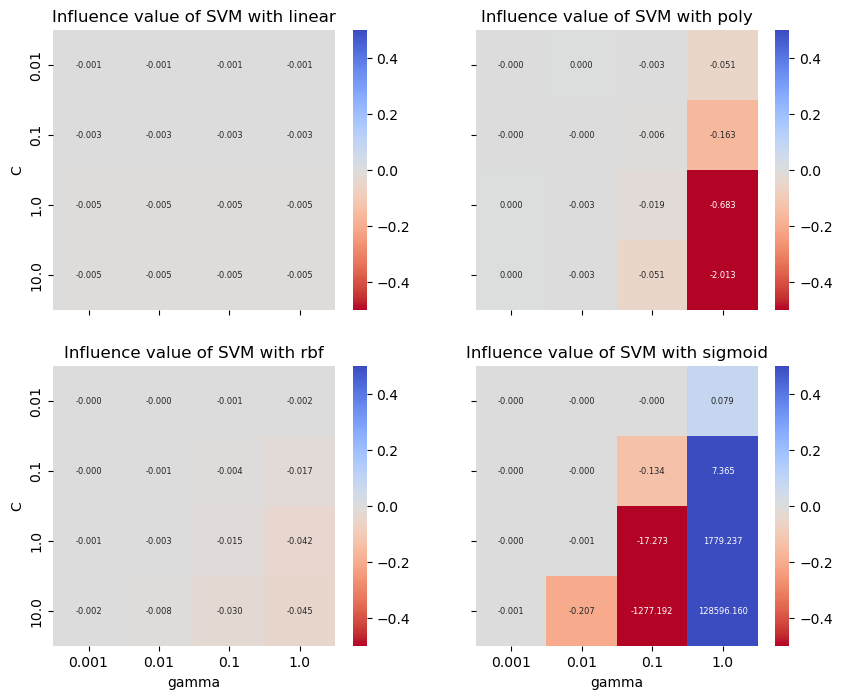

In [16]:
bar_df = pd.DataFrame({'kernel': recording_save_df['kernel'],
                       'C': recording_save_df['C'],
                       'gamma': recording_save_df['gamma'],
                       'influence': recording_save_df['mean_train'] - recording_save_df['mean_test']},
                       index=recording_save_df.index)
bar_df = bar_df.reset_index().drop(columns=['index']).set_index(['kernel'])

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

# Plot heatmap each kernel
for index, kernel in enumerate(bar_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = bar_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['influence'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    sns.heatmap(data_plot, annot=True, ax=ax,
                vmin=-0.5, vmax=0.5, fmt='.3f',
                cmap='coolwarm_r', annot_kws={"size": 6})
    ax.set_title('Influence value of SVM with ' + kernel)
    if index % 2 == 0:
        ax.set_ylabel('C')
        
    if index // 2 == 1:
        ax.set_xlabel('gamma')

plt.show()

The `influence` value has a specific meaning:
- When the value is positive (in blue), it indicates that the MSE of the training dataset is higher than the MSE of the validation dataset. It means that the model performs better on the validation dataset compared to the training dataset.
- When the value is negative (in red), it indicates that the MSE of the training dataset is lower than the MSE of the validation dataset. It means that the model performs better on the training dataset compared to the validation dataset.

It has been observed that the difference between the MSE of the training dataset and validation dataset is larger for SVM with `poly` and `sigmoid` kernels when the hyperparameter value is higher.

Besides, for SVM with `poly` kernel, the `influence` value tends to be redder, which indicates that as the value of the penalty coefficient `C` increases, the model performs better on the training dataset but not on the validation dataset. This suggests that SVM with `poly` kernel is prone to **_overfitting_**.

After conducting `cross-validation` and `hyperparameter-tuning`, `GridSearchCV()` gave the best hyperparameter on my dataset:

In [4]:
# # If you ran Grid Search with cv=5, you can print the best parameters and the best score by code below
# print('SVR: Grid Search with cv=5')
# print('- Kernel: ', reg_gs.best_params_['regressor__kernel'])
# print('- C: ', reg_gs.best_params_['regressor__C'])
# print('- Gamma: ', reg_gs.best_params_['regressor__gamma'])
# print('- Validation MSE: %.6f' % -reg_gs.best_score_)

# Otherwise, you can print the best parameters and the best score by code below
print('SVR: Grid Search with cv=4')
print('- Kernel: ', recording_save_df[recording_save_df['rank_test_score'] == 1]['kernel'].values[0])
print('- C: ', recording_save_df[recording_save_df['rank_test_score'] == 1]['C'].values[0])
print('- Gamma: ', recording_save_df[recording_save_df['rank_test_score'] == 1]['gamma'].values[0])
print('- Validation MSE: %.6f' % recording_save_df[recording_save_df['rank_test_score'] == 1]['mean_test'].values[0])

SVR: Grid Search with cv=4
- Kernel:  rbf
- C:  10.0
- Gamma:  0.01
- Validation MSE: 0.032912


## Evaluate SVM model

In [18]:
# SVM model with best parameters on testing dataset
kernel_best = recording_save_df[recording_save_df['rank_test_score'] == 1]['kernel'].values[0]
C_best = recording_save_df[recording_save_df['rank_test_score'] == 1]['C'].values[0]
gamma_best = recording_save_df[recording_save_df['rank_test_score'] == 1]['gamma'].values[0]

# Create the SVM model
modelSVM = SVR(kernel=kernel_best, C=C_best, gamma=gamma_best)
pipe_svm = Pipeline([('preprocessor', preprocessor),
                      ('regressor', modelSVM)])

# Measure time for training the model
time_start = time.time()
# Training the model on the training dataset
history = pipe_svm.fit(X_train, y_train)
time_end = time.time()

# Evaluate the model on the testing dataset
print('Training for SVM model takes %f seconds' % (time_end - time_start))
print('MSE of SVM: %.6f' % mean_squared_error(y_test, pipe_svm.predict(X_test)))
print('R2 score of SVM: %.6f' % r2_score(y_test, pipe_svm.predict(X_test)))

Training for SVM model takes 1.979696 seconds
MSE of SVM: 0.031149
R2 score of SVM: 0.398953


**Write model evaluation results to csv file**

In [19]:
evaluation = [time_end - time_start, mean_squared_error(y_test, pipe_svm.predict(X_test)),  r2_score(y_test, pipe_svm.predict(X_test))]
with open('evaluation.csv', 'a', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(evaluation)